In [1]:
from PIL import Image
import numpy as np
import cv2
import tensorflow as tf
from scipy.optimize import fmin_l_bfgs_b
import matplotlib.pyplot as plt

C:\Users\Banipreet\Anaconda3\lib\site-packages\h5py\__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


In [2]:
height = 512
width = 512

In [3]:
def flip(x):
    x[:, :, :, 0] -= 103.939
    x[:, :, :, 1] -= 116.779
    x[:, :, :, 2] -= 123.68
    x = x[:, :, :, ::-1]
    return x

def unflip(x):
    x = x[:, :, ::-1]
    x[:, :, 0] += 103.939
    x[:, :, 1] += 116.779
    x[:, :, 2] += 123.68
    return x

content image: 


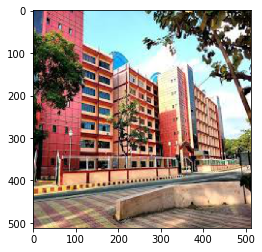

style image: 


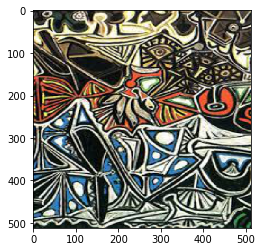

In [4]:
content_image = cv2.imread('data/contents/cimg.jpg')
content_image = cv2.resize(content_image,(width, height))
content_image = cv2.cvtColor(content_image, cv2.COLOR_BGR2RGB)
print('content image: ')
plt.imshow(content_image)
plt.show()
content_image = np.asarray(content_image, dtype='float32')
content_image = np.expand_dims(content_image, axis=0)
content_image = flip(content_image)

style_image = cv2.imread('data/styles/simg.jpg')
style_image = cv2.resize(style_image,(width, height))
style_image = cv2.cvtColor(style_image, cv2.COLOR_BGR2RGB)
print('style image: ')
plt.imshow(style_image)
plt.show()
style_image = np.asarray(style_image, dtype='float32')
style_image = np.expand_dims(style_image, axis=0)
style_image = flip(style_image)

In [5]:
#all the variables, placeholders are defined here
#sess = tf.Session()
content_tensor = tf.Variable(content_image, name='Content_Image')
style_tensor = tf.Variable(style_image, name='Style_Image')
combination_image = tf.placeholder(tf.float32, shape=(1,height,width,3))
loss = tf.Variable(0.,name='Loss')

content_weight = 0.030
style_weight = 3.0
#sess.run(tf.global_variables_initializer())


In [6]:
input_tensor = tf.concat([content_tensor,
                                    style_tensor,
                                    combination_image], axis=0, name='Input_tensor')

In [7]:
model = tf.keras.applications.VGG16(include_top=False, weights='imagenet', input_tensor=input_tensor)

In [8]:
model.summary()
layers = dict([(layer.name, layer.output) for layer in model.layers])

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (3, 512, 512, 3)          0         
_________________________________________________________________
block1_conv1 (Conv2D)        (3, 512, 512, 64)         1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (3, 512, 512, 64)         36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (3, 256, 256, 64)         0         
_________________________________________________________________
block2_conv1 (Conv2D)        (3, 256, 256, 128)        73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (3, 256, 256, 128)        147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (3, 128, 128, 128)        0         
__________

In [9]:
def content_loss(content, combination):
    return tf.reduce_sum(tf.square(combination - content))

layer_features = layers['block2_conv2']
content_image_features = layer_features[0, :, :, :]
combination_features = layer_features[2, :, :, :]


loss += content_weight * content_loss(content_image_features,
                                      combination_features)

In [10]:
def gram_matrix(x):
    features = tf.contrib.layers.flatten(tf.transpose(x)) #n_h x n_w x n_c -> n_c x n_h x n_w -> n_c x n
    gram = tf.matmul(features, tf.transpose(features)) # n_c x n_c
    return gram

In [11]:
def style_loss(style, combination):
    S = gram_matrix(style)
    C = gram_matrix(combination)
    channels = 3
    size = height * width
    return tf.reduce_sum(tf.square(S - C)) / (4. * (channels ** 2) * (size ** 2))

feature_layers = ['block1_conv2', 'block2_conv2',
                  'block3_conv3', 'block4_conv3',
                  'block5_conv3']
for layer_name in feature_layers:
    layer_features = layers[layer_name]
    style_features = layer_features[1, :, :, :]
    combination_features = layer_features[2, :, :, :]
    sl = style_loss(style_features, combination_features)
    loss += (style_weight / len(feature_layers)) * sl
    

In [12]:
grads = tf.gradients(loss, combination_image)
outputs = [loss]
outputs += grads
f_outputs = tf.keras.backend.function([combination_image], outputs)

def eval_loss_and_grads(x):
    x = x.reshape((1, height, width, 3))
    outs = f_outputs([x])
    loss_value = outs[0]
    grad_values = outs[1].flatten().astype('float64')
    return loss_value, grad_values

class Evaluator(object):

    def __init__(self):
        self.loss_value = None
        self.grads_values = None

    def loss(self, x):
        assert self.loss_value is None
        loss_value, grad_values = eval_loss_and_grads(x)
        self.loss_value = loss_value
        self.grad_values = grad_values
        return self.loss_value

    def grads(self, x):
        assert self.loss_value is not None
        grad_values = np.copy(self.grad_values)
        self.loss_value = None
        self.grad_values = None
        return grad_values

evaluator = Evaluator()

In [13]:
def visualize(x):
    img_array = x.reshape((height, width, 3))
    img_array = unflip(img_array)
    img_array = np.clip(img_array, 0, 255).astype('uint8')
    plt.imshow(img_array)
    plt.show()
    return img_array


Initial Image: 


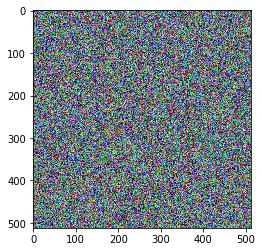

Iteration 1/12:
Loss Value: 124612580000.0
Combined image after iteration  1


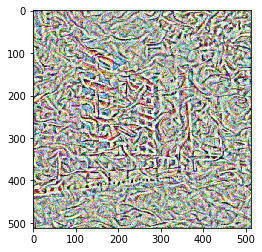

Iteration 2/12:
Loss Value: 63585145000.0
Combined image after iteration  2


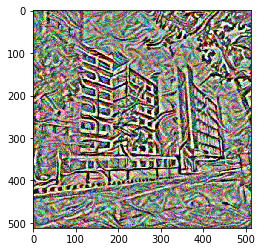

Iteration 3/12:
Loss Value: 48688665000.0
Combined image after iteration  3


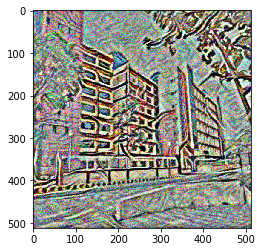

Iteration 4/12:
Loss Value: 49998905000.0
Combined image after iteration  4


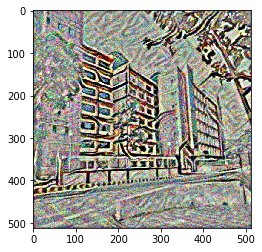

Iteration 5/12:
Loss Value: 46933172000.0
Combined image after iteration  5


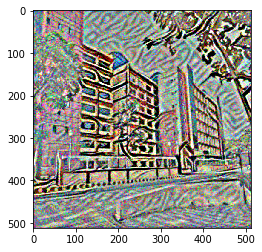

Iteration 6/12:
Loss Value: 49645625000.0
Combined image after iteration  6


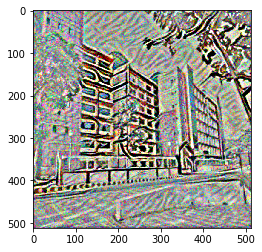

Iteration 7/12:
Loss Value: 47791153000.0
Combined image after iteration  7


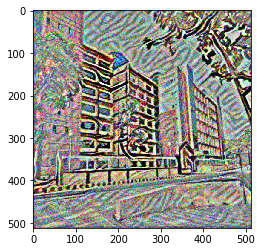

Iteration 8/12:
Loss Value: 50381100000.0
Combined image after iteration  8


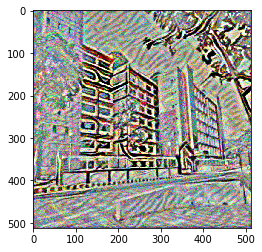

Iteration 9/12:
Loss Value: 47943725000.0
Combined image after iteration  9


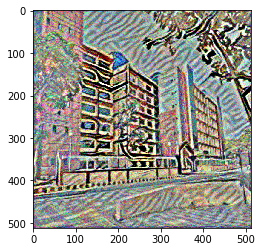

Iteration 10/12:
Loss Value: 50804660000.0
Combined image after iteration  10


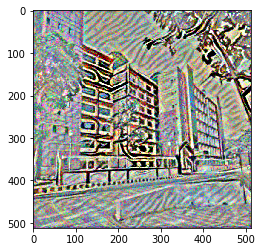

Iteration 11/12:
Loss Value: 48782696000.0
Combined image after iteration  11


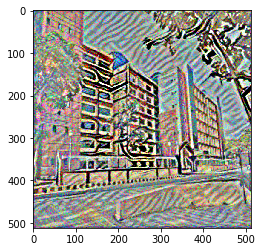

Iteration 12/12:
Loss Value: 49977410000.0
Combined image after iteration  12


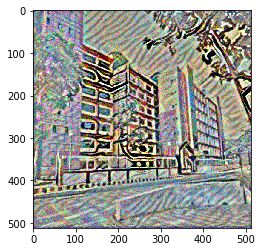

In [14]:
x = np.random.uniform(0, 255, (1, height, width, 3)) - 128.
print('Initial Image: ')
j = Image.fromarray(visualize(x))
j.save('data/sample0.jpg')

iterations = 12

for i in range(iterations):
    print('Iteration '+str(i+1)+'/'+str(iterations)+':')
    x, min_val, _ = fmin_l_bfgs_b(evaluator.loss, x.flatten(), fprime=evaluator.grads, maxfun=20)
    print('Loss Value:', min_val)
    print('Combined image after iteration ',i+1)
    j = Image.fromarray(visualize(x))
    j.save('data/sample'+str(i+1)+'.jpg')